# Avengers Facial Recognition

This project uses Facial Recognition model proposed by Google called **FaceNet**. Facenet uses deep convolutional networks along with triplet loss to achieve high accuracy. 

 Pretrained model from [OpenFacePytorch](https://github.com/thnkim/OpenFacePytorch), which was trained on OpenFace Dataset. Transfer Learning was then applied to train the classifier on the Avengers Dataset.

 **MTCNN** (MultiTask Cascaded Convolution Network) from [facenet-pytorch](https://github.com/timesler/facenet-pytorch) to crop and align the faces

In [ ]:
!pip install facenet-pytorch


     |████████████████████████████████| 1.9 MB 5.2 MB/s 


In [ ]:
import os 
import torch
import numpy as np
import torchvision
from torchvision import datasets, transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
import facenet_pytorch
from facenet_pytorch import MTCNN
from tqdm.notebook import tqdm
import torch.nn as nn
import random

%matplotlib inline


# Check if CUDA GPU is available
useCuda = torch.cuda.is_available()
if useCuda:
    print('CUDA is avialable')
    device = torch.device('cuda:0')
else:
    print('CUDA is not avialable')
    device = torch.device('cpu')
    

CUDA is avialable


## Visualize the Avenger Dataset

Plotting some sample images and Drawing an **histogram** of class Frequencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset ImageFolder
    Number of datapoints: 274
    Root location: /content/drive/MyDrive/cropped_images
    StandardTransform
Transform: Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=None)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


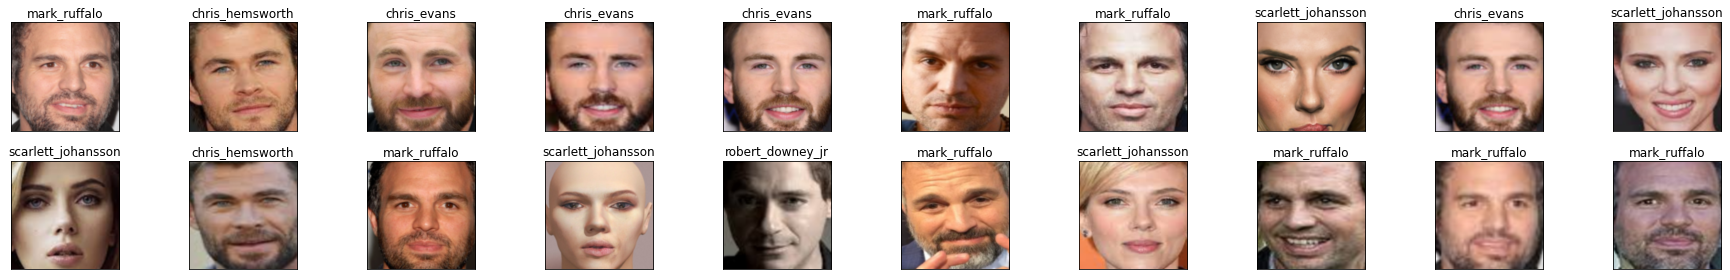

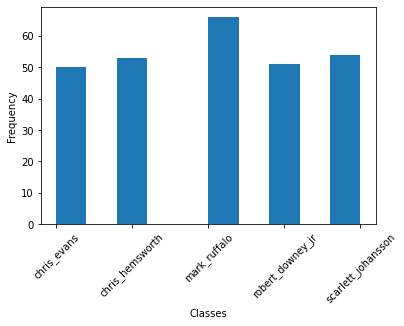

In [ ]:
data_dir = '/content/drive/MyDrive/cropped_images'
dataset = datasets.ImageFolder(data_dir, transform= transforms.Resize((512, 512)))
print(dataset)
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}

batch_size = 32
num_workers = 0 if os.name == 'nt' else 8

# Dataloader for Visualization 
vis_dataloader = torch.utils.data.DataLoader(dataset, 
                                        batch_size=batch_size,
                                        num_workers=num_workers,
                                        shuffle=True,
                                        collate_fn=facenet_pytorch.training.collate_pil)
                             
# Load the of images form the dataloader
dataiter = iter(vis_dataloader)
images, labels = dataiter.next()

# Plt the images
fig = plt.figure(figsize=(25, 4))
for i in np.arange(20):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    plt.imshow(images[i])
    ax.set_title(dataset.idx_to_class[int(labels[i])])
fig.tight_layout()

## Plot the histogram of the class frequency
labels = []
for i in range(len(dataset)):    
    labels.append(dataset.__getitem__(i)[1])
    
fig , ax = plt.subplots()
plt.xticks(range(len(dataset.idx_to_class)), dataset.idx_to_class.values(), rotation=45)
ax.set_xlabel("Classes")
ax.set_ylabel("Frequency")
hist = ax.hist(labels)

del vis_dataloader

## Use MTCNN to Crop and Align Images

In this step we apply the MTCNN model to Align and Crop images. The images are then saved in a new directory as specified in `aligned_data_dir`

In [ ]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

data_dir = '/content/drive/MyDrive/cropped_images'
aligned_data_dir = data_dir + '_aligned'

# Replace the class label with the new path for storing aligned data
dataset.samples = [(p, p.replace(data_dir, aligned_data_dir)) for p, _ in dataset.samples]

batch_size = 32
num_workers = 0 if os.name == 'nt' else 8

dataloader = torch.utils.data.DataLoader(dataset, 
                                        batch_size=batch_size,
                                        num_workers=num_workers,
                                        collate_fn=facenet_pytorch.training.collate_pil)

# Run MTCNN for all the images and save them in new directory
for i, (image, path) in enumerate(tqdm(dataloader, desc="Converting")):
    mtcnn(image, save_path=path)

# Delete to save memory
del mtcnn
del dataloader

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Converting:   0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

## Augmenting the Dataset

As the number of images per class not much, hence we are augmenting the dataset. We are doing this by simply applying **HorizontalFlip** for all the images. Thereby doubling the dataset. We have defined a custom Dataset class `AugmentDataset` which inherits from the `torchvision.datasets.ImageFolder` class.

In [ ]:
class AugmentDataset(datasets.ImageFolder):
    def __init__(self, root, transform = None):
        super().__init__(root, transform)
        self.all_labels = [int(x[1]) for x in self.imgs]
        
        self.horizontalTransform = transforms.RandomHorizontalFlip(1)
    
    def __len__(self):
        return 2 * super().__len__()
    
    def __getitem__(self, item):
        if item < super().__len__():
            image, label = super().__getitem__(item)
        else:
            item -= super().__len__()
            image, label = super().__getitem__(item)
            image = self.horizontalTransform(image)
             
        return image, label

## Splitting the Dataset 

Here we have we split the dataset into Train and test sets. We have reserved 80% of the data for training and the rest 20% for testing the model.

We also initialized the respective train and test dataloaders from their respective dataset.

In [ ]:
transform = transforms.Compose([transforms.Resize(96),
                                transforms.ToTensor()])

data_dir = '/content/drive/MyDrive/cropped_images'
aligned_data_dir = data_dir + '_aligned'

# dataset = datasets.ImageFolder(aligned_data_dir, transform=transform)
dataset = AugmentDataset(aligned_data_dir, transform=transform)
idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}

total_count = len(dataset)
train_count = int(0.8 * total_count)
test_count = total_count - train_count

train_dataset, test_dataset = torch.utils.data.random_split(dataset,
                                                           [train_count, test_count])
print('Total Images : ', total_count)
print('Num of Train Images : ', len(train_dataset))
print('Num of Test Images : ', len(test_dataset))

batch_size = 64
num_workers = 0 if os.name == 'nt' else 8

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                              num_workers=num_workers, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                             num_workers=num_workers, shuffle=True)




Total Images :  548
Num of Train Images :  438
Num of Test Images :  110


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Triplet Loss and Triplet Generator

Here we train the model such it learns the face embeddings $f(x)$ from the image $x$ such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large.


This loss minimizes the distance between an anchor image  and a positive image  and maximizes the between the anchor image  and a negative image  

The `generate_triplets` function generates these positive and negative images for the entire batch. The current implementation randomly chooses the positive and negative images from the current batch. This can easily be enhanced to select difficult triplets to make the model train better. 

The difficult triplet can be generated by selecting the positive image having the highest distance from the anchor and similarly selcting the negative image having smallest distance from the anchor

In [ ]:
# Generate triplets
def generate_triplets(images, labels):
    positive_images = []
    negative_images = []
    batch_size = len(labels)
    
    for i in range(batch_size):
        anchor_label = labels[i]

        positive_list = []
        negative_list = []

        for j in range(batch_size):
            if j != i:
                if labels[j] == anchor_label:
                    positive_list.append(j)
                else:
                    negative_list.append(j)

        positive_images.append(images[random.choice(positive_list)])
        negative_images.append(images[random.choice(negative_list)])

    positive_images = torch.stack(positive_images)
    negative_images = torch.stack(negative_images)
    
    return positive_images, negative_images

class TripletLoss(nn.Module):
    def __init__(self, alpha=0.2):
        super(TripletLoss, self).__init__()
        self.alpha = alpha
    
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor, positive, negative): # (batch_size , emb_size)
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.alpha)
        return losses.mean()


## Define the Model, Optimizer and Loss Function

In [ ]:
!pip install OpenFace

ERROR: Could not find a version that satisfies the requirement OpenFace (from versions: none)
ERROR: No matching distribution found for OpenFace


In [ ]:
import sys
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from collections import OrderedDict
try:
    from . SpatialCrossMapLRN_temp import SpatialCrossMapLRN_temp
except:
    try:
        from SpatialCrossMapLRN_temp import SpatialCrossMapLRN_temp
    except:
        SpatialCrossMapLRN_temp = None
import os
import time

import pathlib
containing_dir = str(pathlib.Path('/content/drive/MyDrive/openface.pth').resolve().parent)


class LambdaBase(nn.Sequential):
    def __init__(self, fn, *args):
        super(LambdaBase, self).__init__(*args)
        self.lambda_func = fn

    def forward_prepare(self, input):
        output = []
        for module in self._modules.values():
            output.append(module(input))
        return output if output else input


class Lambda(LambdaBase):
    def forward(self, input):
        return self.lambda_func(self.forward_prepare(input))


#
def Conv2d(in_dim, out_dim, kernel, stride, padding):
    l = torch.nn.Conv2d(in_dim, out_dim, kernel, stride=stride, padding=padding)
    return l

def BatchNorm(dim):
    l = torch.nn.BatchNorm2d(dim)
    return l

def CrossMapLRN(size, alpha, beta, k=1.0, gpuDevice=0):
    if SpatialCrossMapLRN_temp is not None:
        lrn = SpatialCrossMapLRN_temp(size, alpha, beta, k, gpuDevice=gpuDevice)
        n = Lambda( lambda x,lrn=lrn: Variable(lrn.forward(x.data).cuda(gpuDevice)) if x.data.is_cuda else Variable(lrn.forward(x.data)) )
    else:
        n = nn.LocalResponseNorm(size, alpha, beta, k).cuda(gpuDevice)
    return n

def Linear(in_dim, out_dim):
    l = torch.nn.Linear(in_dim, out_dim)
    return l


class Inception(nn.Module):
    def __init__(self, inputSize, kernelSize, kernelStride, outputSize, reduceSize, pool, useBatchNorm, reduceStride=None, padding=True):
        super(Inception, self).__init__()
        #
        self.seq_list = []
        self.outputSize = outputSize

        #
        # 1x1 conv (reduce) -> 3x3 conv
        # 1x1 conv (reduce) -> 5x5 conv
        # ...
        for i in range(len(kernelSize)):
            od = OrderedDict()
            # 1x1 conv
            od['1_conv'] = Conv2d(inputSize, reduceSize[i], (1, 1), reduceStride[i] if reduceStride is not None else 1, (0,0))
            if useBatchNorm:
                od['2_bn'] = BatchNorm(reduceSize[i])
            od['3_relu'] = nn.ReLU()
            # nxn conv
            pad = int(numpy.floor(kernelSize[i] / 2)) if padding else 0
            od['4_conv'] = Conv2d(reduceSize[i], outputSize[i], kernelSize[i], kernelStride[i], pad)
            if useBatchNorm:
                od['5_bn'] = BatchNorm(outputSize[i])
            od['6_relu'] = nn.ReLU()
            #
            self.seq_list.append(nn.Sequential(od))

        ii = len(kernelSize)
        # pool -> 1x1 conv
        od = OrderedDict()
        od['1_pool'] = pool
        if ii < len(reduceSize) and reduceSize[ii] is not None:
            i = ii
            od['2_conv'] = Conv2d(inputSize, reduceSize[i], (1,1), reduceStride[i] if reduceStride is not None else 1, (0,0))
            if useBatchNorm:
                od['3_bn'] = BatchNorm(reduceSize[i])
            od['4_relu'] = nn.ReLU()
        #
        self.seq_list.append(nn.Sequential(od))
        ii += 1

        # reduce: 1x1 conv (channel-wise pooling)
        if ii < len(reduceSize) and reduceSize[ii] is not None:
            i = ii
            od = OrderedDict()
            od['1_conv'] = Conv2d(inputSize, reduceSize[i], (1,1), reduceStride[i] if reduceStride is not None else 1, (0,0))
            if useBatchNorm:
                od['2_bn'] = BatchNorm(reduceSize[i])
            od['3_relu'] = nn.ReLU()
            self.seq_list.append(nn.Sequential(od))

        self.seq_list = nn.ModuleList(self.seq_list)


    def forward(self, input):
        x = input

        ys = []
        target_size = None
        depth_dim = 0
        for seq in self.seq_list:
            #print(seq)
            #print(self.outputSize)
            #print('x_size:', x.size())
            y = seq(x)
            y_size = y.size()
            #print('y_size:', y_size)
            ys.append(y)
            #
            if target_size is None:
                target_size = [0] * len(y_size)
            #
            for i in range(len(target_size)):
                target_size[i] = max(target_size[i], y_size[i])
            depth_dim += y_size[1]

        target_size[1] = depth_dim
        #print('target_size:', target_size)

        for i in range(len(ys)):
            y_size = ys[i].size()
            pad_l = int((target_size[3] - y_size[3]) // 2)
            pad_t = int((target_size[2] - y_size[2]) // 2)
            pad_r = target_size[3] - y_size[3] - pad_l
            pad_b = target_size[2] - y_size[2] - pad_t
            ys[i] = F.pad(ys[i], (pad_l, pad_r, pad_t, pad_b))

        output = torch.cat(ys, 1)

        return output


class netOpenFace(nn.Module):
    def __init__(self, useCuda, gpuDevice=0):
        super(netOpenFace, self).__init__()

        self.gpuDevice = gpuDevice

        self.layer1 = Conv2d(3, 64, (7,7), (2,2), (3,3))
        self.layer2 = BatchNorm(64)
        self.layer3 = nn.ReLU()
        self.layer4 = nn.MaxPool2d((3,3), stride=(2,2), padding=(1,1))
        self.layer5 = CrossMapLRN(5, 0.0001, 0.75, gpuDevice=gpuDevice)
        self.layer6 = Conv2d(64, 64, (1,1), (1,1), (0,0))
        self.layer7 = BatchNorm(64)
        self.layer8 = nn.ReLU()
        self.layer9 = Conv2d(64, 192, (3,3), (1,1), (1,1))
        self.layer10 = BatchNorm(192)
        self.layer11 = nn.ReLU()
        self.layer12 = CrossMapLRN(5, 0.0001, 0.75, gpuDevice=gpuDevice)
        self.layer13 = nn.MaxPool2d((3,3), stride=(2,2), padding=(1,1))
        self.layer14 = Inception(192, (3,5), (1,1), (128,32), (96,16,32,64), nn.MaxPool2d((3,3), stride=(2,2), padding=(0,0)), True)
        self.layer15 = Inception(256, (3,5), (1,1), (128,64), (96,32,64,64), nn.LPPool2d(2, (3,3), stride=(3,3)), True)
        self.layer16 = Inception(320, (3,5), (2,2), (256,64), (128,32,None,None), nn.MaxPool2d((3,3), stride=(2,2), padding=(0,0)), True)
        self.layer17 = Inception(640, (3,5), (1,1), (192,64), (96,32,128,256), nn.LPPool2d(2, (3,3), stride=(3,3)), True)
        self.layer18 = Inception(640, (3,5), (2,2), (256,128), (160,64,None,None), nn.MaxPool2d((3,3), stride=(2,2), padding=(0,0)), True)
        self.layer19 = Inception(1024, (3,), (1,), (384,), (96,96,256), nn.LPPool2d(2, (3,3), stride=(3,3)), True)
        self.layer21 = Inception(736, (3,), (1,), (384,), (96,96,256), nn.MaxPool2d((3,3), stride=(2,2), padding=(0,0)), True)
        self.layer22 = nn.AvgPool2d((3,3), stride=(1,1), padding=(0,0))
        self.layer25 = Linear(736, 128)

        #
        self.resize1 = nn.UpsamplingNearest2d(scale_factor=3)
        self.resize2 = nn.AvgPool2d(4)

        #
        # self.eval()

        if useCuda:
            self.cuda(gpuDevice)


    def forward(self, input):
        x = input

        if x.data.is_cuda and self.gpuDevice != 0:
            x = x.cuda(self.gpuDevice)

        #
        if x.size()[-1] == 128:
            x = self.resize2(self.resize1(x))

        x = self.layer8(self.layer7(self.layer6(self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x))))))))
        x = self.layer13(self.layer12(self.layer11(self.layer10(self.layer9(x)))))
        x = self.layer14(x)
        x = self.layer15(x)
        x = self.layer16(x)
        x = self.layer17(x)
        x = self.layer18(x)
        x = self.layer19(x)
        x = self.layer21(x)
        x = self.layer22(x)
        x = x.view((-1, 736))

        x_736 = x

        x = self.layer25(x)
        x_norm = torch.sqrt(torch.sum(x**2, 1) + 1e-6)
        x = torch.div(x, x_norm.view(-1, 1).expand_as(x))

        # return (x, x_736)
        # return x
        return x_736


def prepareOpenFace(useCuda=True, gpuDevice=0, useMultiGPU=False):
    model = netOpenFace(useCuda, gpuDevice)
    model.load_state_dict(torch.load(os.path.join(containing_dir, 'openface.pth')))

    if useMultiGPU:
        model = nn.DataParallel(model)

    return model


In [ ]:
# from loadOpenFace import prepareOpenFace

model = prepareOpenFace(useCuda)
model.eval()
print("Model Loaded")

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = TripletLoss()

Model Loaded


## Training the model

In [ ]:
n_epochs = 10

for epoch in tqdm(range(n_epochs), desc="epoch"):
    
    train_loss = 0 
    count = 0
    
    ## Training Loop
    model.train()
    for batch, (images, labels) in enumerate(tqdm(train_dataloader, \
                                             desc="Training", leave=False)):
        
        positives , negatives = generate_triplets(images, labels)
        
        # Move tensor to device
        images, labels = images.to(device), labels.to(device)
        positives, negatives = positives.to(device), negatives.to(device) 
        
        optimizer.zero_grad()
        
        # Seaseme Network
        anchor_out = model(images)
        positive_out = model(positives)
        negative_out = model(negatives)
        
        # Get the loss
        loss = loss_fn(anchor_out, positive_out, negative_out)
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.detach().item()
        count =  len(labels)
        

    print('Epoch : %d/%d - Loss: %0.4f' % 
          (epoch+1, n_epochs, train_loss / count))
    train_loss = 0.0

model.eval()
print("Training Done")

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch : 1/10 - Loss: 0.0684


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 2/10 - Loss: 0.0371


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 3/10 - Loss: 0.0051


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 4/10 - Loss: 0.0025


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 5/10 - Loss: 0.0025


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 6/10 - Loss: 0.0017


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 7/10 - Loss: 0.0021


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 8/10 - Loss: 0.0033


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 9/10 - Loss: 0.0035


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 10/10 - Loss: 0.0001
Training Done


## Testing the Model

In [ ]:
def distance(emb1, emb2):
    return torch.sum(torch.square(emb1 - emb2)).numpy()

# Generate Embeddings and label vector
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))
(images, labels) = next(iter(test_dl))
positives , negatives = generate_triplets(images, labels)

images, labels = images.to(device), labels.to(device)
positives, negatives = positives.to(device), negatives.to(device) 

with torch.no_grad():
    embeddings = model(images)
    
embeddings = embeddings.cpu()
labels = labels.cpu()


### Visualizing the Output

As we can see the model is able to generate the face embeddings for the dataset. Now if had to use just the distance between these embeddings to predict the faces, we would get an accuracy close to **95%**.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


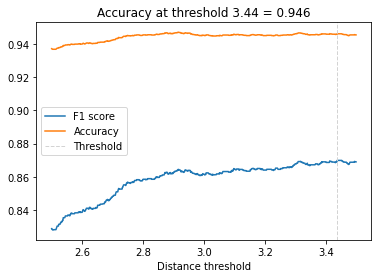

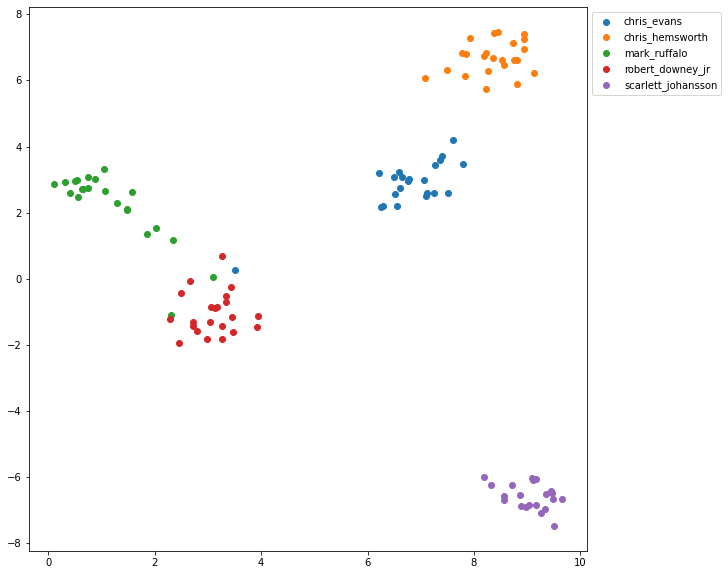

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(labels)

for i in range(num-1):
    for j in range(1, num):
        distances.append(distance(embeddings[i], embeddings[j]))
        identical.append(1 if labels[i] == labels[j] else 0)

distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(2.5, 3.5, 0.001)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

# Visualize the Result
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embeddings)

plt.figure(figsize=(10,10))


for i, t in enumerate(set(labels.numpy())):
    idx = (t == labels.numpy())
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=idx_to_class[t])

plt.legend(bbox_to_anchor=(1, 1));

# Saving the Model

Saving the model only if the current model accuracy is better or if any previous model checkpoint doesn't exist

In [ ]:
chk_path = '/content/drive/MyDrive/helper/AvengersClassifier_FaceNet_nn4_small2_v1.pth'

def save_model(model, chk_path, current_accuracy=1.0):
    '''Saves the model only if model doesnt exist or
       if the model accuracy is better'''
    try:
        checkpoint = torch.load(chk_path)
        if(current_accuracy < checkpoint['accuracy']):
            print("Not Saving, Previous model was better")
            return
        
    except FileNotFoundError:
        print("Previous model not found")
        
    torch.save({
        'model_state_dict' : model.state_dict(),
        'accuracy' : current_accuracy
    }, chk_path)

    print("Model Saved : %s" % chk_path)

save_model(model, chk_path, opt_acc)

Not Saving, Previous model was better


### Loading the Saved Model

In [ ]:
# Load the model
chk_path = 'models/AvengersClassifier_FaceNet_nn4_small2_v1.pth'

def load_model(model, chk_path):
    try:
        checkpoint = torch.load(chk_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Model Loaded from %s" % chk_path)
        return model
    except FileNotFoundError:
        print("Model checkpoint not found %s" % chk_path)
        return None

model = load_model(model, chk_path)
        

Model checkpoint not found models/AvengersClassifier_FaceNet_nn4_small2_v1.pth


# Transfer Learning a new classifier

The current model just outputs a face embedding for the image. To create a classifer for the __Avenger Dataset__ we add a new `nn.Linear` layer at the end, this layer takes in the face embedding and predicts the class label.

Since we only need to train the final layer, we freeze the parameters for all layers except the final layer. 



In [ ]:
from collections import OrderedDict

n_classes = len(dataset.class_to_idx)

classifier_model = nn.Sequential(OrderedDict([
                                    ("nn4_small_v2", model),
                                    ("fc",  nn.Linear(736, n_classes))
                                ]))

classifier_model = classifier_model.to(device)

# Freeze the parameters in the nn4_small_v2 layer
for param in classifier_model.parameters():
    param.requires_grad = False

for param in classifier_model.fc.parameters():
    param.requires_grad = True
    

optimizer = optim.Adam(classifier_model.fc.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

### Training the Classifier

In [ ]:
def train(n_epochs, dataloader, model, optimizer, loss_fn):
    '''returns Trained classifier model'''
    
    for epoch in tqdm(range(n_epochs), desc="epoch"):

        train_loss = 0.0
        count = 0
        
        # Training loop 
        model.train()
        for batch, (images, labels) in enumerate(tqdm(dataloader, desc= "Training", leave=False)):
            
            # Move Tensor to appropriate device
            images, labels = images.to(device), labels.to(device)
 
            optimizer.zero_grad()
            print(type(model))
            out = model(images)
            
            # Get the loss
            loss = loss_fn(out, labels)
            loss.backward()

            optimizer.step()

            train_loss += loss.detach().item()
            count =  len(labels)


        print('Epoch : %d/%d - Loss: %0.4f' % 
              (epoch+1, n_epochs, train_loss / count))
        train_loss = 0.0

    model.eval()
    print("Training Done")
    return model

classifier_model = train(10 , train_dataloader, classifier_model, optimizer, loss_fn)
    

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


<class 'torch.nn.modules.container.Sequential'>


ValueError: ignored

### Testing the Classifier

In [ ]:
def test(dataloader, model, loss_fn):
    
    test_loss = 0.0
    total = 0
    correct = 0

    # Testing loop 
    model.eval()
    for batch, (images, labels) in enumerate(tqdm(dataloader, desc="Testing")):

        # Move Tensor to appropriate device
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            out = model(images)

        loss = loss_fn(out, labels)
        test_loss += loss.detach().item()
        
        # Get the class with max probability
        pred = out.data.max(1, keepdim=True)[1]
        # Compare predictions with true label
        correct += np.sum(np.squeeze(pred.eq(labels.view_as(pred))).cpu().numpy())
        total += labels.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss/total))
    print('Test Accuracy : %d%% (%d/%d)' % (
            100 * correct / total, correct, total))
    
    return(float(correct / total))
    

current_accuracy = test(test_dataloader, classifier_model, loss_fn)
    

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TypeError: ignored

As we can see we got a test Accuracy of 100%

# Save the Final Classifier

In [ ]:
chk_path = '/content/drive/MyDrive/helper/AvengersClassifier.pth'

def save_model(model, chk_path, idx_to_class, current_accuracy=1.0):
    '''Saves the model only if model doesnt exist or
       if the previous model accuracy was better'''
    try:
        checkpoint = torch.load(chk_path)
        if(current_accuracy < checkpoint['accuracy']):
            print("Not Saving, Previous model was better")
            return
        
    except FileNotFoundError:
        print("Previous model not found")
        
    torch.save({
        'model_state_dict' : model.state_dict(),
        'accuracy' : current_accuracy,
        'idx_to_class': idx_to_class
    }, chk_path)

    print("Model Saved : %s" % chk_path)

save_model(classifier_model, chk_path, idx_to_class, current_accuracy)

In [ ]:
# Load the model
chk_path = '/content/drive/MyDrive/helper/AvengersClassifier.pth'

def load_model(model, chk_path):
    '''Returns model and idx_to_class dictionary'''
    try:
        checkpoint = torch.load(chk_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Model Loaded from %s" % chk_path)
        return model, checkpoint['idx_to_class']
    except FileNotFoundError:
        print("Model checkpoint not found %s" % chk_path)
        return None

classifier_model, idx_to_class = load_model(classifier_model, chk_path)
        

# Using the Classifer for doing Predictions

In [ ]:
from torch.nn import Softmax
from facenet_pytorch import MTCNN
from PIL import Image
from torchvision import transforms 

mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=False,
    device=device
)

face_transform = transforms.Compose([transforms.Resize(96),
                                    transforms.ToTensor()])

classifier_model = classifier_model.to(device)
classifier_model.eval()

softmax = Softmax(dim=1)

In [ ]:
def predict_and_display(img_path, prob_theshold = 0.9):
    img = Image.open(img_path)
    
    # Plt the image
    fig = plt.figure()
    ## Plt original image
    ax1 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    plt.imshow(img)
    ax1.set_title("Original Image")
    
    # Crop, Align and standardize the Image 
    mtcnn_img = mtcnn(img.convert('RGB'))
    
    if mtcnn_img is None:
        plt.show()
        print("ERROR, Could not detect a face in image")
        return
    
    # convert to PIL image
    mtcnn_img = Image.fromarray(np.array(mtcnn_img.permute(1, 2, 0).numpy(), dtype=np.uint8))

    ## Plt MTCNN image
    ax1 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    plt.imshow(mtcnn_img)
    ax1.set_title("MTCNN Image")
    fig.tight_layout()
    plt.show()

    
    # Do the Prediction
    mtcnn_img = face_transform(mtcnn_img).unsqueeze(0)
    mtcnn_img = mtcnn_img.to(device)

    with torch.no_grad():
        label = classifier_model(mtcnn_img)
        label = softmax(label) # To Convert the logit to probabilities

    prob, pred = label.data.max(1, keepdim=True)
    prob, pred = float(prob), int(pred)

    if prob < prob_theshold:
        print("UNKNOWN FACE, but similar to %s with %0.2f%% probability" %
                 (idx_to_class[pred], 100 * prob))
    else:
        print("%s with %0.2f%% probability" %
                 (idx_to_class[pred], 100 * prob))
        

In [ ]:
import os

img_dir = './sample'
for file in os.listdir(img_dir):
    img_path = os.path.join(img_dir, file)
    predict_and_display(img_path)